# Credit Card Fraud Detection

* Contains transactions made with credit cards by European cardholders in September 2013.
* Presents transactions from two days, including 284,807 transactions, of which 492 are fraud.
* The exact nature of the columns, except for transaction and amount, is unknown due to privacy reasons.
* Unknown columns are scaled.
* Transaction amounts are small, with an average of $88.
* No null values are present.
* Data is highly imbalanced: 99.83% normal transactions and 0.17% fraudulent transactions.
* PCA Transformation: The dataset description states that all features have undergone a PCA transformation (Dimensionality Reduction technique), except for time and amount.
* Scaling: To apply PCA transformation, features need to be scaled beforehand. In this case, all V features are scaled, or at least it is assumed that the dataset creators have done so.
* Features V1, V2, ..., V28 are the principal components obtained through PCA; the only features not transformed by PCA are 'Time' and 'Amount'. The 'Time' feature contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the transaction amount, which can be used for cost-sensitive learning depending on the sample. The 'Class' feature is the response variable, which takes a value of 1 in case of fraud and 0 otherwise.
* The dataset was collected through a collaboration between the Machine Learning Group of ULB (Université Libre de Bruxelles) and Worldline for big data mining and fraud detection.
    * Kaynak: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
        * Çalışmalar:
            * https://paperswithcode.com/dataset/kaggle-credit-card-fraud-dataset
            * https://www.researchgate.net/profile/Mohammed-Al-Shabi/publication/335526336_Credit_Card_Fraud_Detection_Using_Autoencoder_Model_in_Unbalanced_Datasets/links/5f2a7901a6fdcccc43ac10d4/Credit-Card-Fraud-Detection-Using-Autoencoder-Model-in-Unbalanced-Datasets.pdf
            * https://github.com/tusharsarkar3/XBNet
            * https://arxiv.org/pdf/2106.05239v3.pdf
            * https://arxiv.org/pdf/1911.08623v1.pdf
            * https://github.com/GuansongPang/deviation-network
            * https://github.com/xuhongzuo/DeepOD
            * https://github.com/Ryosaeba8/Anomaly_detection
            * https://github.com/robeespi/Deep-Semi-supervised-intrusion-detection-on-unstructured-Hadoop-distributed-file-system-logs
            * https://github.com/robeespi/Weakly-Supervised-Malware-Detection
            * https://arxiv.org/pdf/2206.06602v2.pdf
            * https://github.com/xuhongzuo/deep-iforest
            * https://arxiv.org/pdf/2211.06675v1.pdf (+ IEEE CIS Data set)
            * https://github.com/davidnugent2425/he-cc-fraud-detection


## Importing Libraries

In [1]:
!pip3 install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [2]:
! pip install -q kaggle

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


import os



import sys




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Importing the Dataset

In [4]:
from google.colab import files

In [5]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"vedantkul2004","key":"c8aec647e7e0171252ca9ec359a604f7"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle (2).json

cp: cannot stat 'kaggle.json': No such file or directory
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: ` chmod 600 ~/.kaggle/kaggle (2).json'


In [7]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 62% 41.0M/66.0M [00:00<00:00, 148MB/s] 
100% 66.0M/66.0M [00:00<00:00, 170MB/s]


In [8]:
! unzip creditcardfraud.zip -d creditcardfraud

Archive:  creditcardfraud.zip
  inflating: creditcardfraud/creditcard.csv  


In [9]:
data = pd.read_csv('creditcardfraud/creditcard.csv')
df = data.copy()

# Examining the Structure of the Dataset

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
def show_graphs(df):
    fraud_counts = df['Class'].value_counts()

    # pie chart
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.pie(fraud_counts, labels=['Non-fraudulent', 'Fraudulent'], colors=['lightblue', 'red'], autopct='%1.1f%%')
    ax1.set_title('Transaction Class Distribution')

    # bar plot
    ax2.bar(['Non-fraudulent', 'Fraudulent'], fraud_counts.values, color=['lightblue', 'red'])
    ax2.set_xlabel('Transaction Class')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Credit Card Fraud Detection')
    for i in ax2.containers:
        ax2.bar_label(i,)

    plt.show()

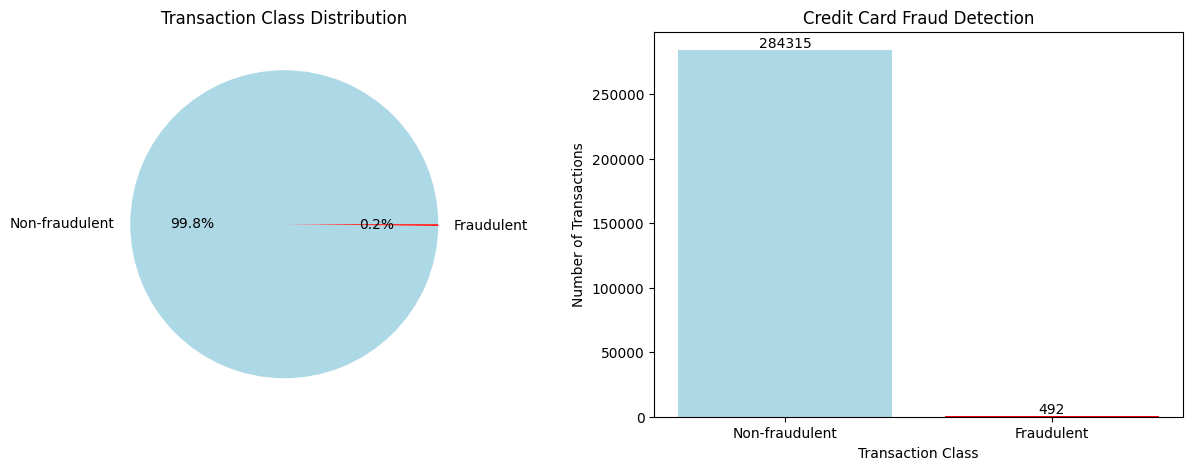

In [14]:
show_graphs(df)

In [15]:
non_fradulent_count = df['Class'].value_counts()[0]
fradulent_count = df['Class'].value_counts()[1]

print(f"Normal operation count =  {non_fradulent_count} (% {non_fradulent_count/len(df)*100})")
print(f"Number of fraudulent transactions = {fradulent_count} (% {fradulent_count/len(df)*100})")

Normal operation count =  284315 (% 99.82725143693798)
Number of fraudulent transactions = 492 (% 0.1727485630620034)


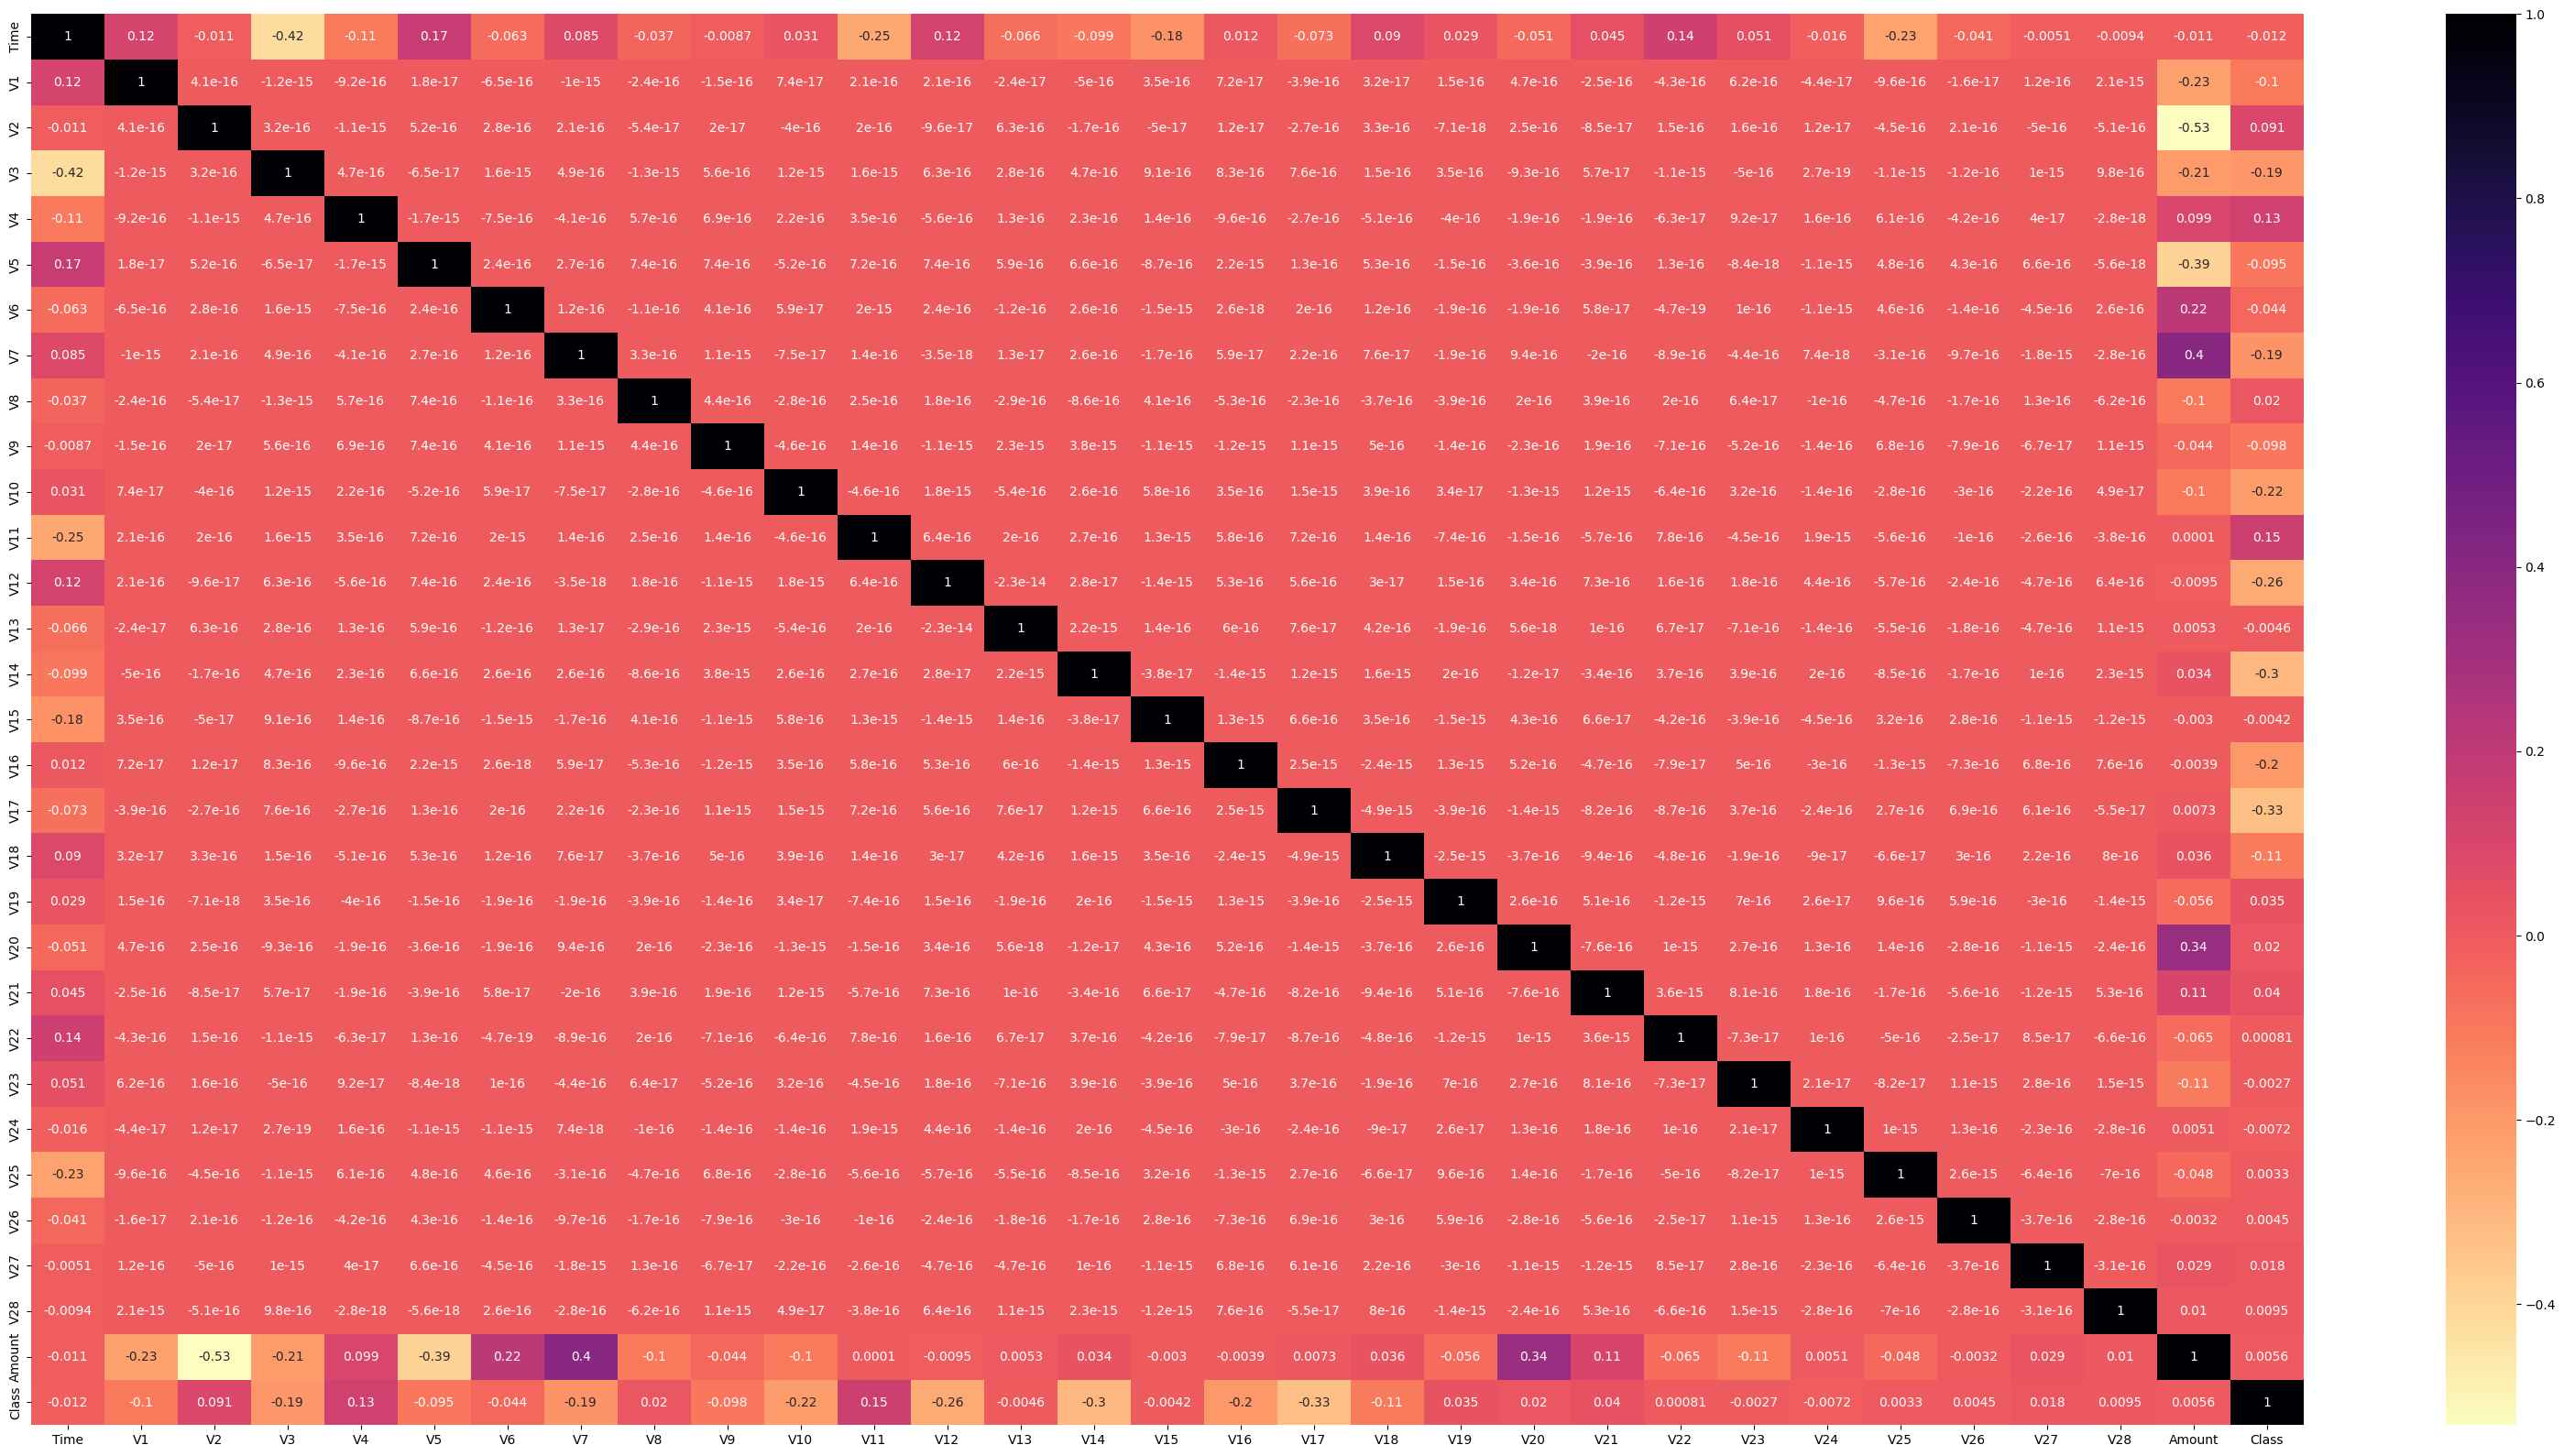

In [16]:
plt.figure(figsize = (40,20))
sns.heatmap(df.corr(), cmap="magma_r", annot=True);

# Data Preprocessing

* It is known that all features except for the "Time" and "amount" columns have undergone PCA transformation.
  Based on this information, it can be said that the features, except for the specified columns, have been scaled.
    * This is because features need to be scaled in order to undergo PCA transformation.


In [17]:
df.drop_duplicates(inplace=True)

### Outlier Handling

In [18]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))

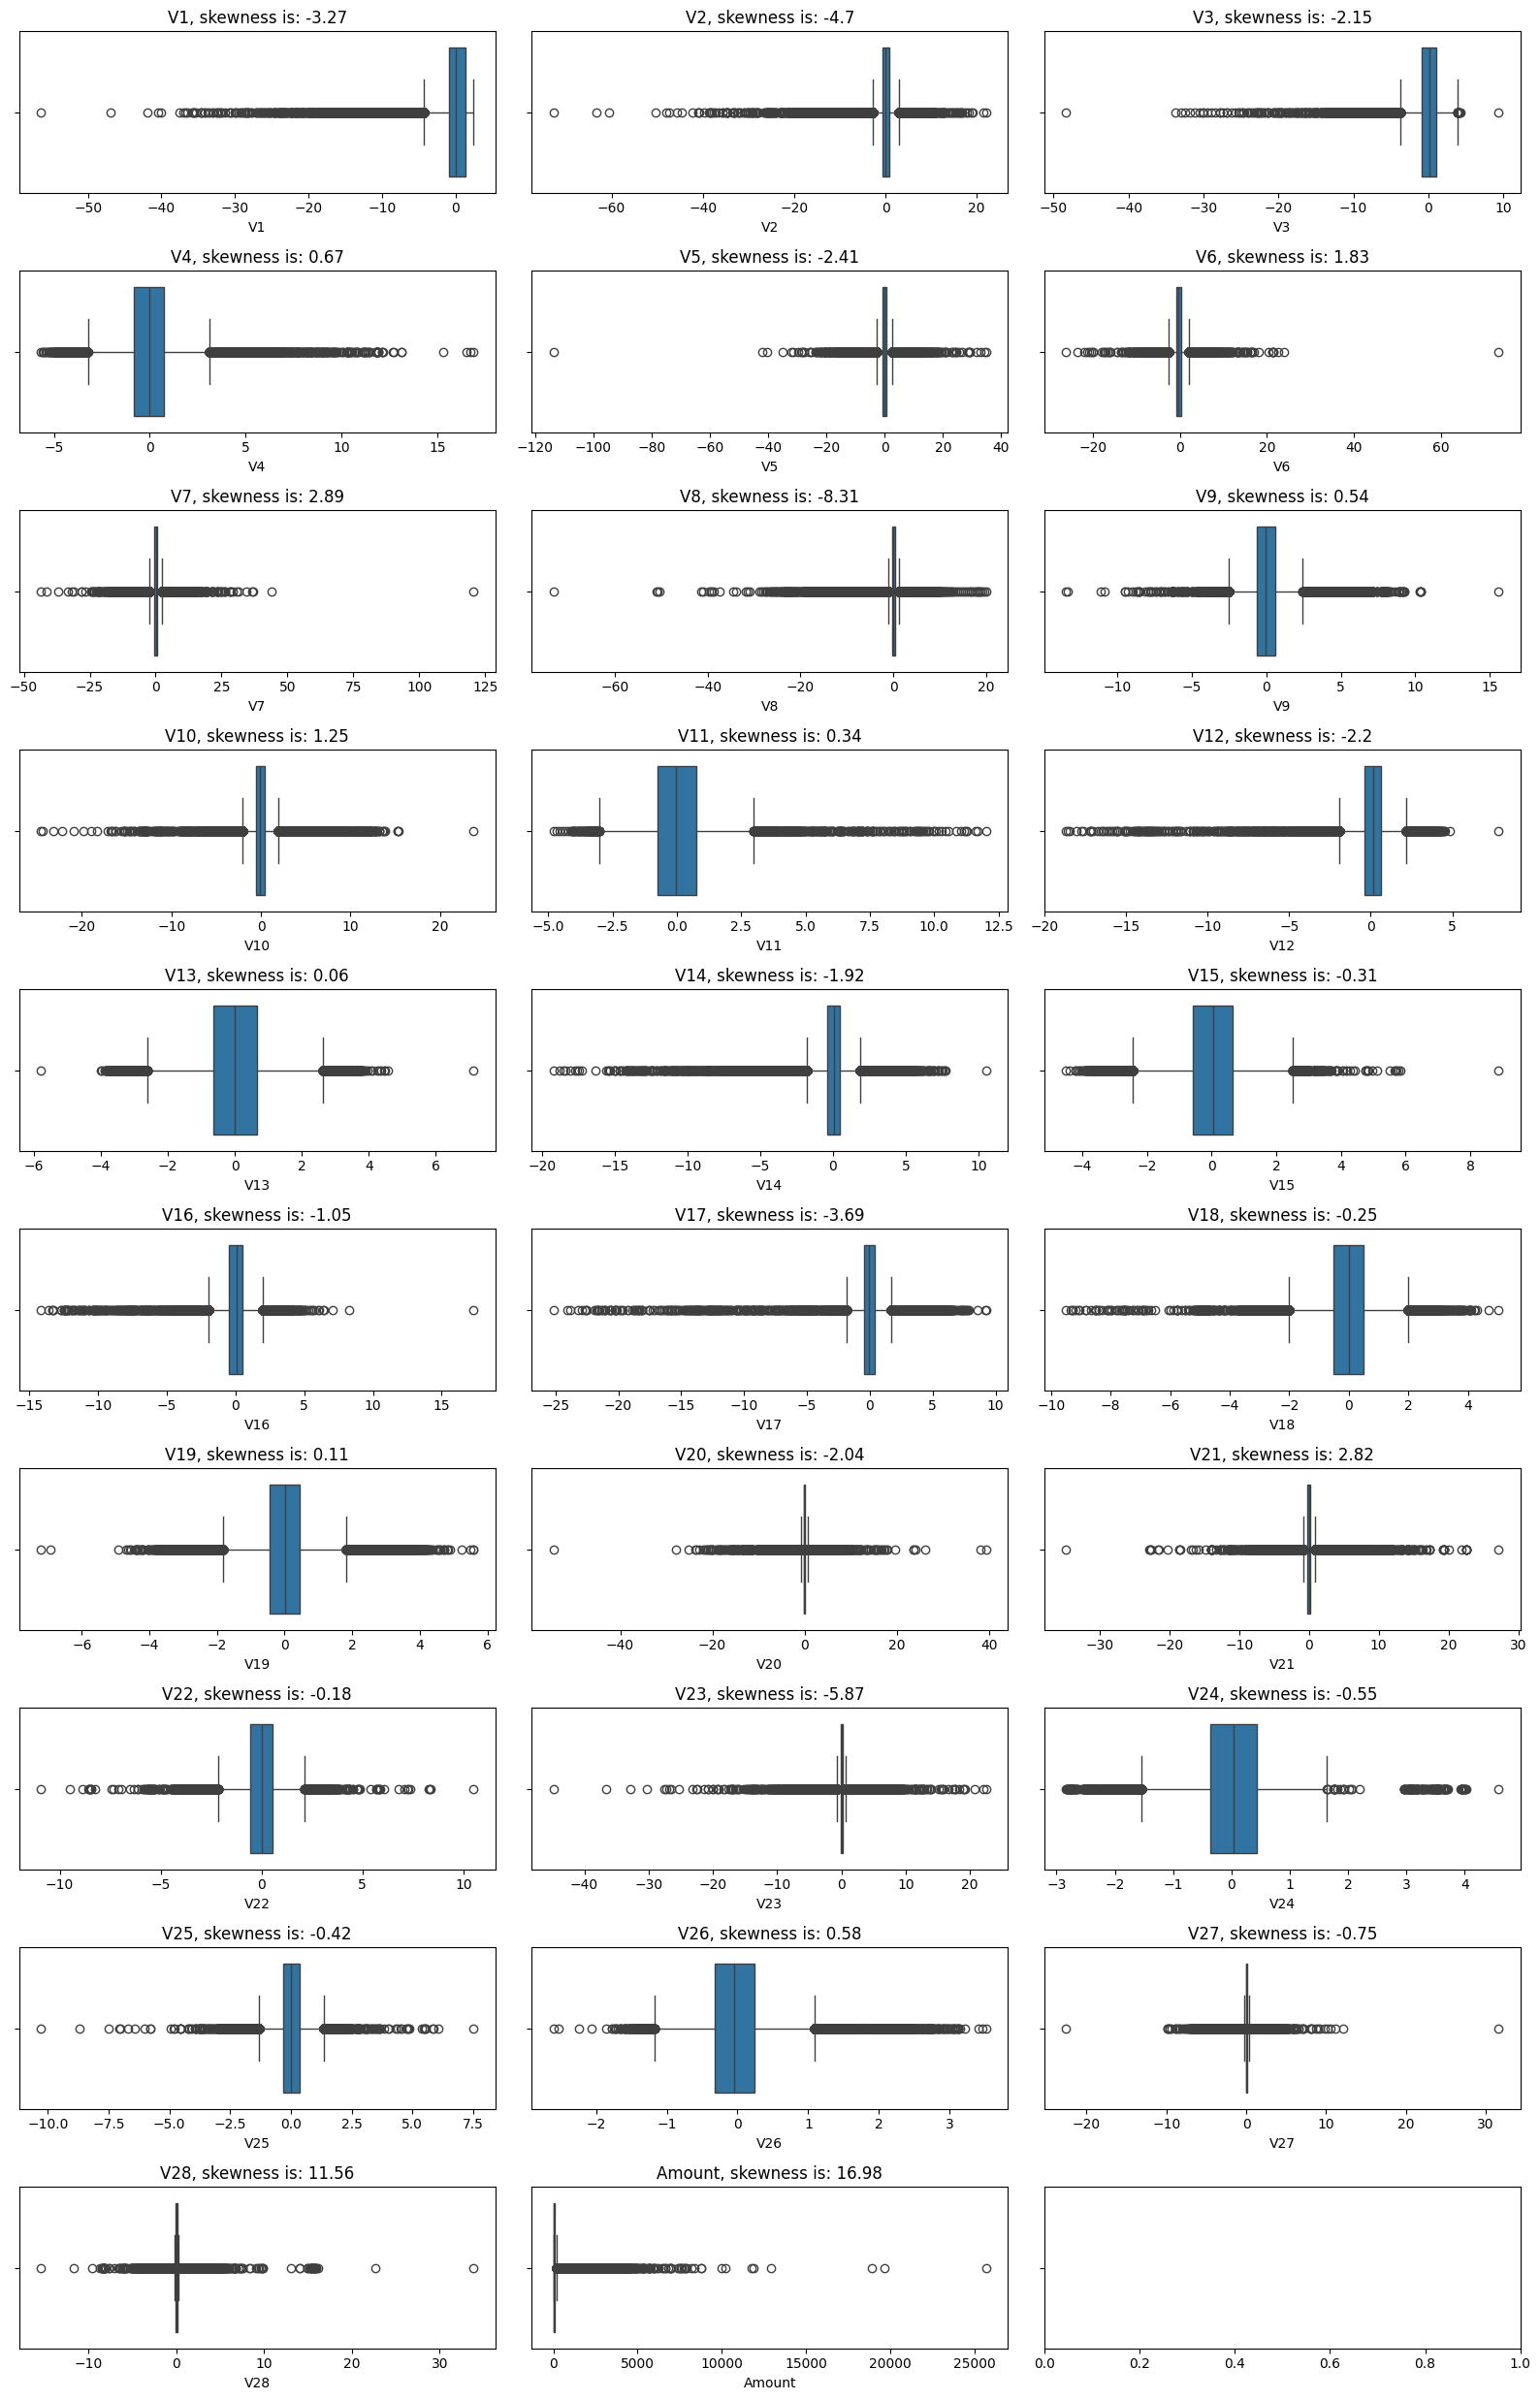

In [19]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='')
plt.tight_layout()

In [20]:
df["Class"].unique()

array([0, 1])

## Feature Selection

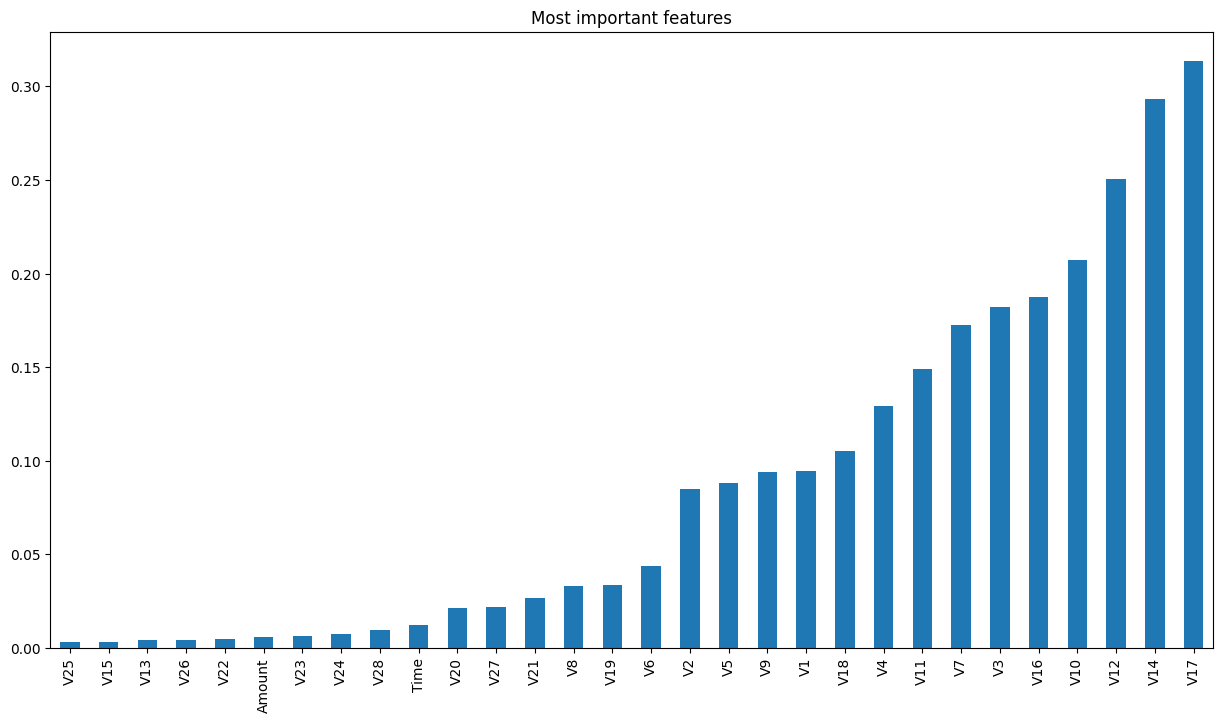

In [21]:
plt.figure(figsize=(15,8))
d = df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Most important features')

plt.show()

In [22]:
selected_features = df.corr()['Class'][:-1].abs() > 0.15

print (selected_features)

Time      False
V1        False
V2        False
V3         True
V4        False
V5        False
V6        False
V7         True
V8        False
V9        False
V10        True
V11       False
V12        True
V13       False
V14        True
V15       False
V16        True
V17        True
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Name: Class, dtype: bool


# Splitting the Dataset

### Stratified Splitting


* The subsets of this dataset are typically created randomly based on a target variable. However, when doing this, especially with small datasets, the proportions of the target variable across different subsets may vary.

* With this technique, equal class percentages are ensured across the split training and test portions.

In [23]:
amount = df['Amount'].values.reshape(-1, 1)

scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount)

df['Amount'] = amount_scaled

In [24]:
X = df.drop('Class', axis=1)
y = df['Class']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [26]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244200,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342584,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.158900,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.139886,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073813,0


In [27]:
pd.DataFrame(y_train).value_counts()

,count
Class,
0,198269
1,339


In [28]:
pd.DataFrame(y_test).value_counts()

,count
Class,
0,84984
1,134


# Model Creation

## Application of Oversampling/Undersampling Techniques

![download%20%281%29.png](attachment:download%20%281%29.png)

* At this point, one of the most important factors to consider is that the dataset should be split before applying the technique. The main purpose of this is to avoid altering the structure of the test set.

* Applying the oversampling technique without splitting the dataset can result in the same observations being present in both the test and training sets. This can lead to the model memorizing only certain data points, causing overfitting and poor generalization on test data. Although not entirely invalid, data leakage can lead to overly optimistic prediction models.
    * Data leakage occurs when information from outside the training dataset is used to create the model.

### Random Oversampling

In [ ]:
# Sampling-based data augmentation can lead to overfitting

In [29]:
from imblearn.over_sampling import RandomOverSampler
# Instantiate the RandomOverSampler
ros = RandomOverSampler()
# Apply the oversampling
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)


In [30]:
X_train_ros.shape

(396538, 30)

### Random Undersampling

In [31]:
# Intentional reduction of data can lead to underfitting.

In [32]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler()

# Apply the undersampling
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


In [33]:
X_train_rus.shape

(678, 30)

### SMOTE

* SMOTE (Synthetic Minority Oversampling Technique) synthesizes elements for the minority class. SMOTE works by selecting nearby examples in the feature space, drawing a line between these examples in the feature space, and generating a new example at a point along this line.

![download%20%282%29.png](attachment:download%20%282%29.png)

In [34]:
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE
smote = SMOTE()

# Apply SMOTE to balance the dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [35]:
X_train_smote.shape

(396538, 30)

### ADASYN

In [36]:
from imblearn.over_sampling import ADASYN

# Instantiate the ADASYN
adasyn = ADASYN()

# Apply ADASYN to balance the dataset
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)


In [37]:
X_train_adasyn.shape

(396444, 30)

# Model Creation and Training

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

In [49]:
isf = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isf.fit(X_train)
y_pred = isf.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84984
           1       0.03      0.76      0.06       134

    accuracy                           0.96     85118
   macro avg       0.52      0.86      0.52     85118
weighted avg       1.00      0.96      0.98     85118



ml_models_list = [
    
                  lgb.LGBMClassifier(),
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  CatBoostClassifier(),
                  XGBClassifier(),
                  LogisticRegression(),
                  RandomForestClassifier(),
                  KNeighborsClassifier(),
                  GaussianNB(),
                  DecisionTreeClassifier(),                  
]             

In [ ]:
ml_models_list = [

                  lgb.LGBMClassifier(),
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  CatBoostClassifier(),
                  XGBClassifier(),
]

## Comparison of Untreated Models

In [ ]:
metrics_list = []

# Iterate over each model
for model in ml_models_list:
    # Train the model
    model_name = model.__class__.__name__  # Get model class name as model name
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # Probabilities for AUC for each class

    # Calculate metrics for class 0
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    auc_0 = roc_auc_score(y_test == 0, y_pred_proba[:, 0])

    # Calculate metrics for class 1
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    auc_1 = roc_auc_score(y_test == 1, y_pred_proba[:, 1])

    # Append metrics to the list
    metrics_list.append({
        'model_name': model_name,
        'precision(0)': precision_0,
        'recall(0)': recall_0,
        'f1_score(0)': f1_0,
        'auc(0)': auc_0,
        'precision(1)': precision_1,
        'recall(1)': recall_1,
        'f1_score(1)': f1_1,
        'auc(1)': auc_1
    })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)

[LightGBM] [Info] Number of positive: 339, number of negative: 198269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 198608, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001707 -> initscore=-6.371380
[LightGBM] [Info] Start training from score -6.371380
Learning rate set to 0.098669
0:	learn: 0.3652020	total: 101ms	remaining: 1m 40s
1:	learn: 0.2003993	total: 151ms	remaining: 1m 15s
2:	learn: 0.1094787	total: 203ms	remaining: 1m 7s
3:	learn: 0.0619073	total: 247ms	remaining: 1m 1s
4:	learn: 0.0368903	total: 295ms	remaining: 58.6s
5:	learn: 0.0235441	total: 339ms	remaining: 56.2s
6:	learn: 0.0158623	total: 386ms	remaining: 54.8s
7:	learn: 0.0113793	total: 433ms	remaining: 53.7s
8:	learn: 0.0083235	total: 479ms	remaining: 52.7s
9:	learn: 0.0066759	tota

In [ ]:
y_test.value_counts()

Class
0    84984
1      134
Name: count, dtype: int64

In [ ]:
df_metrics

,model_name,precision(0),recall(0),f1_score(0),auc(0),precision(1),recall(1),f1_score(1),auc(1)
0,LGBMClassifier,0.999305,0.997976,0.998640,0.712652,0.303644,0.559701,0.393701,0.698949
1,AdaBoostClassifier,0.999424,0.999823,0.999624,0.971421,0.850000,0.634328,0.726496,0.971421
2,GradientBoostingClassifier,0.999177,0.999871,0.999524,0.623083,0.853333,0.477612,0.612440,0.623090
3,CatBoostClassifier,0.999588,0.999941,0.999765,0.983538,0.951923,0.738806,0.831933,0.983538
4,XGBClassifier,0.999647,0.999941,0.999794,0.972923,0.954128,0.776119,0.855967,0.973102


In [ ]:
df_metrics.sort_values(by='f1_score(1)')

,model_name,precision(0),recall(0),f1_score(0),auc(0),precision(1),recall(1),f1_score(1),auc(1)
0,LGBMClassifier,0.999305,0.997976,0.998640,0.712652,0.303644,0.559701,0.393701,0.698949
2,GradientBoostingClassifier,0.999177,0.999871,0.999524,0.623083,0.853333,0.477612,0.612440,0.623090
1,AdaBoostClassifier,0.999424,0.999823,0.999624,0.971421,0.850000,0.634328,0.726496,0.971421
3,CatBoostClassifier,0.999588,0.999941,0.999765,0.983538,0.951923,0.738806,0.831933,0.983538
4,XGBClassifier,0.999647,0.999941,0.999794,0.972923,0.954128,0.776119,0.855967,0.973102


## Comparison of Models Balanced with Various Techniques

In [51]:
X = [X_train_ros, X_train_rus, X_train_smote, X_train_adasyn]
y = [y_train_ros, y_train_rus, y_train_smote, y_train_adasyn]
Method = ['Random Oversampling', 'Random Undersampling', 'SMOTE', 'ADASYN']

for i in range(len(X)):
  isf = IsolationForest(n_estimators=200, contamination='auto', random_state=42)
  isf.fit(X[i])
  y_pred = isf.predict(X_test)
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  report = classification_report(y_test, y_pred)
  print(Method[i])
  print(report)

Random Oversampling
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84984
           1       0.03      0.22      0.05       134

    accuracy                           0.99     85118
   macro avg       0.51      0.61      0.52     85118
weighted avg       1.00      0.99      0.99     85118

Random Undersampling
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84984
           1       0.03      0.21      0.05       134

    accuracy                           0.99     85118
   macro avg       0.52      0.60      0.52     85118
weighted avg       1.00      0.99      0.99     85118

SMOTE
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84984
           1       0.02      0.22      0.04       134

    accuracy                           0.98     85118
   macro avg       0.51      0.60      0.52     85118
weighted avg       1.00    

In [ ]:
from sklearn import svm
X = [X_train_ros, X_train_rus, X_train_smote, X_train_adasyn]
y = [y_train_ros, y_train_rus, y_train_smote, y_train_adasyn]
Method = ['Random Oversampling', 'Random Undersampling', 'SMOTE', 'ADASYN']

for i in range(len(X)):
  ocsvm = svm.OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
  ocsvm.fit(X[i])
  y_pred = isf.predict(X_test)
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  report = classification_report(y_test, y_pred)
  print(Method[i])
  print(report)

In [ ]:
new_metric_list = []
X = [X_train_ros, X_train_rus, X_train_smote, X_train_adasyn]
y = [y_train_ros, y_train_rus, y_train_smote, y_train_adasyn]
Method = ['Random Oversampling', 'Random Undersampling', 'SMOTE', 'ADASYN']

# Iterate over each model
for model in ml_models_list:
    # Train the model
    model_name = model.__class__.__name__  # Get model class name as model name
    for i in range(len(X)):
      model.fit(X[i], y[i])

      # Make predictions
      y_pred = model.predict(X_test)
      y_pred_proba = model.predict_proba(X_test)  # Probabilities for AUC for each class

      # Calculate metrics for class 0
      precision_0 = precision_score(y_test, y_pred, pos_label=0)
      recall_0 = recall_score(y_test, y_pred, pos_label=0)
      f1_0 = f1_score(y_test, y_pred, pos_label=0)
      auc_0 = roc_auc_score(y_test == 0, y_pred_proba[:, 0])

      # Calculate metrics for class 1
      precision_1 = precision_score(y_test, y_pred, pos_label=1)
      recall_1 = recall_score(y_test, y_pred, pos_label=1)
      f1_1 = f1_score(y_test, y_pred, pos_label=1)
      auc_1 = roc_auc_score(y_test == 1, y_pred_proba[:, 1])

      # Append metrics to the list
      new_metric_list.append({
          'model_name': model_name,
          'Method Applied': Method[i],
          'precision(0)': precision_0,
          'recall(0)': recall_0,
          'f1_score(0)': f1_0,
          'auc(0)': auc_0,
          'precision(1)': precision_1,
          'recall(1)': recall_1,
          'f1_score(1)': f1_1,
          'auc(1)': auc_1
      })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)

[LightGBM] [Info] Number of positive: 198269, number of negative: 198269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7648
[LightGBM] [Info] Number of data points in the train set: 396538, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6787
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
df_new_metrics = pd.DataFrame(new_metric_list)

NameError: name 'pd' is not defined

In [ ]:
df_new_metrics

,model_name,Method Applied,precision(0),recall(0),f1_score(0),auc(0),precision(1),recall(1),f1_score(1),auc(1)
0,LGBMClassifier,Random Oversampling,0.999671,0.999694,0.999682,0.963124,0.814286,0.802817,0.808511,0.963124
1,LGBMClassifier,Random Undersampling,0.999840,0.955788,0.977318,0.983232,0.033196,0.908451,0.064052,0.983232
2,LGBMClassifier,SMOTE,0.999694,0.999282,0.999488,0.964966,0.655367,0.816901,0.727273,0.964966
3,LGBMClassifier,ADASYN,0.999670,0.999294,0.999482,0.972698,0.655172,0.802817,0.721519,0.972698
4,AdaBoostClassifier,Random Oversampling,0.999761,0.984419,0.992031,0.981469,0.084371,0.859155,0.153652,0.981469
5,AdaBoostClassifier,Random Undersampling,0.999864,0.948338,0.973420,0.982292,0.028976,0.922535,0.056187,0.982292
6,AdaBoostClassifier,SMOTE,0.999750,0.986867,0.993266,0.967265,0.097817,0.852113,0.175489,0.967265
7,AdaBoostClassifier,ADASYN,0.999726,0.988373,0.994017,0.967336,0.107498,0.838028,0.190552,0.967336
8,GradientBoostingClassifier,Random Oversampling,0.999799,0.993198,0.996487,0.982379,0.177809,0.880282,0.295858,0.982379
9,GradientBoostingClassifier,Random Undersampling,0.999900,0.938983,0.968484,0.984319,0.025193,0.943662,0.049075,0.984319


In [ ]:
df_new_metrics.to_csv("Handling_imbalance.csv",index = False)
df_metrics.to_csv("Not_handling.csv",index = False)

## Comparison of Performances

# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
ml_models_list = [

                  lgb.LGBMClassifier(),
                  #AdaBoostClassifier(),
                  #GradientBoostingClassifier(),
                  CatBoostClassifier(),
                  #XGBClassifier()
]

In [ ]:
params = {
    'n_estimators': [5,6,7,8],
    'max_depth': [2,3,4,5],
    'random_state': [0,1]
}

for i in ml_models_list:
    grid_rf = GridSearchCV(i, param_grid=params,
                       cv=kf, scoring='f1').fit(X_train, y_train)
    print(i, 'baseline Best parameters:', grid_rf.best_params_)
    print(i, 'baseline Best score:', grid_rf.best_score_)

In [ ]:
grid_rf.best_params_